In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cifar-10/trainLabels.csv
/kaggle/input/cifar-10/sampleSubmission.csv
/kaggle/input/cifar-10/test.7z
/kaggle/input/cifar-10/train.7z


In [2]:
from fastai.vision.all import *


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
!pip install py7zr


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.3/412.3 kB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.8/138.8 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.8/49.8 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 69.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 6.1 MB/s eta 0:00:00


In [4]:
from py7zr import unpack_7zarchive
import shutil
shutil.register_unpack_format('7zip',['.7z'],unpack_7zarchive)

In [5]:
shutil.unpack_archive('../input/cifar-10/train.7z', '/kaggle/temp/')


In [6]:
train_labels = pd.read_csv("../input/cifar-10/trainLabels.csv", header="infer")

classes = train_labels['label'].unique()
print(classes)

['frog' 'truck' 'deer' 'automobile' 'bird' 'horse' 'ship' 'cat' 'dog'
 'airplane']


In [7]:
if not os.path.exists("/kaggle/temp/valid"):
    os.mkdir("/kaggle/temp/valid")
    
parent_path_train = "/kaggle/temp/train"
parent_path_valid = "/kaggle/temp/valid"
# parent_path_test = "/kaggle/temp/test"

for class1 in classes:
    path_train = os.path.join(parent_path_train,class1)
    if not os.path.exists(path_train):
        os.mkdir(path_train)
    path_valid = os.path.join(parent_path_valid,class1)
    if not os.path.exists(path_valid):
        os.mkdir(path_valid)
for (int_ind,row) in train_labels.iterrows():
    id = str(row["id"])+".png"
    source_path = os.path.join(parent_path_train,id)
    
    p=np.random.random()
    if p<=0.8:
        target_path = os.path.join(parent_path_train,row["label"],id)
        os.replace(source_path, target_path)
    else:
        target_path = os.path.join(parent_path_valid,row["label"],id)
        os.replace(source_path, target_path)

In [8]:
dls=ImageDataLoaders.from_folder(path='/kaggle/temp',
                            train='train', valid='valid',item_tfms=Resize(224),bs=64)

In [9]:
os.listdir('/kaggle/temp')

['valid', 'train']

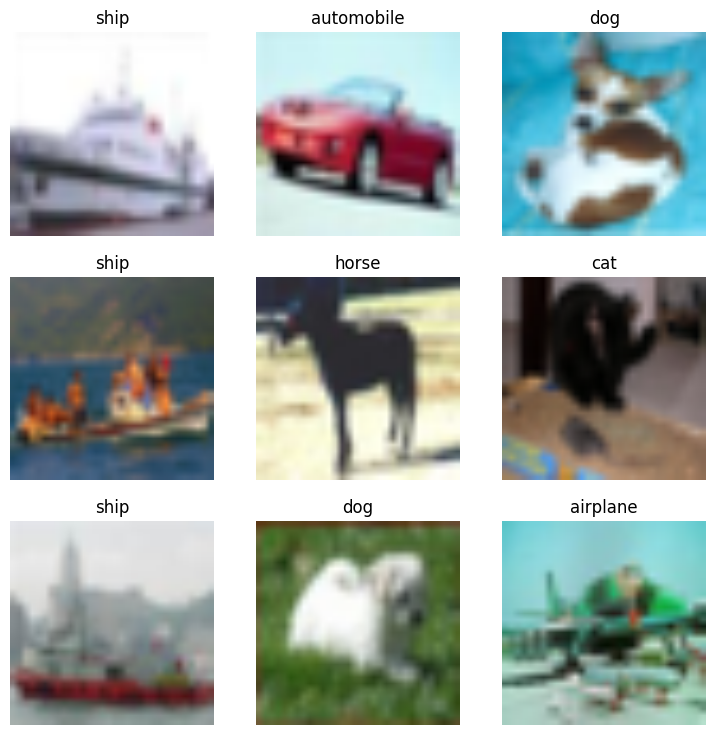

In [10]:
dls.show_batch()

In [11]:
learn = vision_learner(dls, resnet50, metrics=accuracy)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 236MB/s]


SuggestedLRs(valley=0.0008317637839354575)

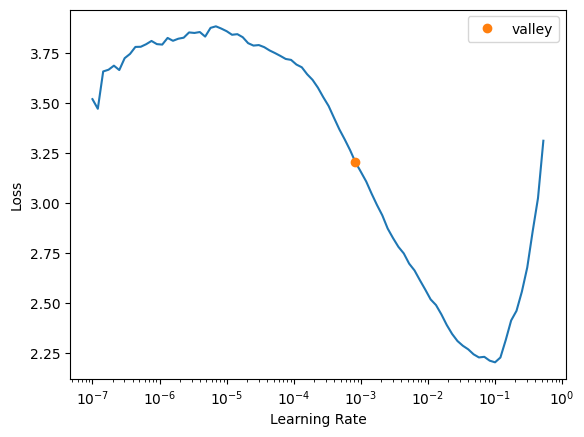

In [12]:
learn.lr_find()


In [13]:
learn.fit_one_cycle(3, 3e-3)


epoch,train_loss,valid_loss,accuracy,time
0,0.356049,0.315506,0.895172,03:03
1,0.221715,0.169149,0.940197,03:02
2,0.122355,0.127564,0.956453,03:03


In [14]:
learn.unfreeze()


SuggestedLRs(valley=1.9054607491852948e-06)

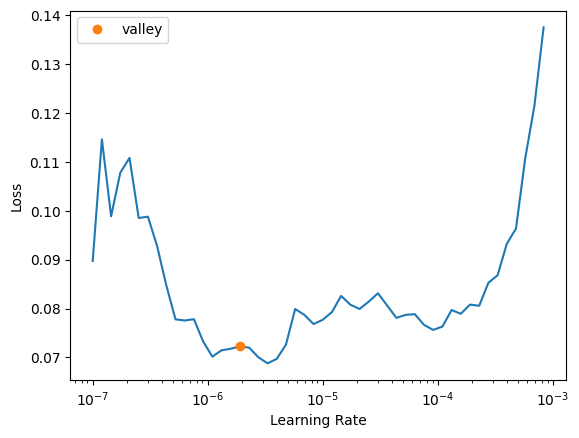

In [15]:
learn.lr_find()


In [16]:
learn.fit_one_cycle(5, lr_max=slice(1e-6,3e-5))


epoch,train_loss,valid_loss,accuracy,time
0,0.080878,0.128032,0.957340,03:50
1,0.060994,0.121677,0.958621,03:50
2,0.041664,0.122482,0.959803,03:50
3,0.031778,0.124180,0.958227,03:49
4,0.027670,0.122284,0.959606,03:48


In [17]:
#from fastai.callback.fp16 import *
# learn = vision_learner(dls, resnet18, metrics=accuracy)
# learn.fine_tune(10, freeze_epochs=3)


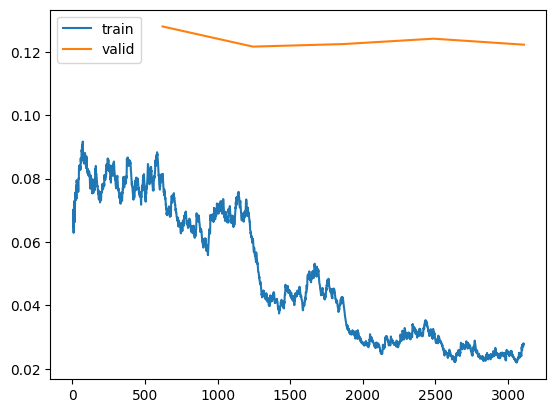

In [18]:
learn.recorder.plot_loss()


In [19]:
shutil.unpack_archive('/kaggle/input/cifar-10/test.7z','/kaggle/temp/test')
shutil.unregister_unpack_format('7zip')

In [20]:
learn.save('/kaggle/working/vision')

Path('/kaggle/working/vision.pth')

In [21]:
# os.listdir('/kaggle/temp/test/test')

In [22]:
len(os.listdir('/kaggle/temp/test/test'))

300000

In [23]:
path='/kaggle/temp/test/test'
f=os.listdir(path)
new=[str(path)+'/'+s for s in f]

In [24]:
test_dl=learn.dls.test_dl(new)


In [25]:
class_score,y=learn.get_preds(dl=test_dl)


In [26]:
class_score

tensor([[1.8736e-07, 9.9999e-01, 1.7841e-08,  ..., 7.1901e-09, 6.2250e-08,
         1.3930e-05],
        [1.2678e-05, 1.8548e-04, 1.1463e-04,  ..., 1.9177e-04, 3.7648e-04,
         3.2049e-04],
        [1.2192e-08, 1.9321e-08, 7.9376e-06,  ..., 9.8649e-07, 5.4553e-07,
         1.8178e-07],
        ...,
        [3.5694e-02, 4.8680e-04, 1.3769e-02,  ..., 9.1225e-03, 5.5418e-03,
         5.5098e-01],
        [3.4218e-10, 5.5336e-10, 2.3050e-09,  ..., 6.9406e-09, 5.6186e-11,
         1.9486e-10],
        [6.1039e-06, 1.1426e-07, 1.9005e-06,  ..., 7.0304e-06, 4.1013e-07,
         1.6264e-07]])

In [27]:
class_score = np.argmax(class_score, axis=1)


In [28]:
class_score[1].item()


6

In [29]:
class_score

tensor([1, 6, 4,  ..., 9, 5, 4])

In [30]:
classScore=class_score.tolist()

In [31]:
len(classScore)

300000

In [32]:
learn.dls.vocab

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [33]:
classes={0:'airplane',1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'}

In [34]:
predicted_classes=np.empty(shape=300000,dtype=np.dtype('U20'))

In [35]:
ind=0
for i in (classScore):
    predicted_classes[ind]=classes[i]
    ind=ind+1

In [36]:
predicted_classes

array(['automobile', 'frog', 'deer', ..., 'truck', 'dog', 'deer'],
      dtype='<U20')

In [37]:
directory = '/kaggle/temp/test/test'
ImageId = [ (''.join(filter(str.isdigit, name ))) for name in os.listdir(directory)]

In [38]:
submission  = pd.DataFrame({
    "id": ImageId,
    "label": predicted_classes
})
# submission.sort_values(by=["ImageId"], inplace = True)
submission.to_csv("submission.csv", index=False)
display(submission.head(3))
display(submission.tail(3))

,id,label
0,287200,automobile
1,33557,frog
2,281872,deer


,id,label
299997,253814,truck
299998,17297,dog
299999,259315,deer


In [39]:
submission['id']=submission['id'].astype(int)


In [40]:
submission.to_csv('submission.csv', index=False)

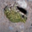

In [41]:
im = Image.open('/kaggle/temp/test/test/134190.png')
im.to_thumb(254,254)
